# Investigating mass-to-light ratios and SAGA comparison stuff

In [2]:
# first we import all relevant packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic
import pickle
import pandas as pd

pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

In [3]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})
mpl.rcParams['hatch.linewidth'] = 0.8

In [4]:
def read_timescales():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('../../Data/QuenchingTimescales.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

In [121]:
def read_z0(simname):
    '''Function to read in the data file which contains z=0 information for the various halos'''
    data = []
    with open('../../Data/z0_data/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break
    data1 = pd.DataFrame(data)
    data1['sim'] = [simname]*len(data1)
    return data1

In [24]:
timescales = read_timescales()
quenched = np.array(timescales.quenched, dtype=bool)
tau = np.array(timescales.tinfall) - np.array(timescales.tquench)
quench_after_infall = tau > 0

resolved = np.array(timescales.n_star, dtype=int) > 100
satellites = ~np.isnan(np.array(timescales.tinfall))

timescales = timescales[quenched & quench_after_infall]

len(timescales)

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


22

In [41]:
timescales = read_timescales()
quenched = np.array(timescales.quenched, dtype=bool)
tau = np.array(timescales.tinfall) - np.array(timescales.tquench)
quench_after_infall = tau > 0

resolved = np.array(timescales.n_star, dtype=int) > 100
satellites = ~np.isnan(np.array(timescales.tinfall))

timescales = timescales[quenched & satellites & resolved]

print(f'There are {len(timescales)} resolved satellites that are quenched at z=0.')

gas_masses = np.array([])
sims, haloids = np.array(timescales.sim), np.array(timescales.haloid)
for sim, haloid in zip(sims,haloids):
    d = read_z0(sim)
    d = d[d.haloid==haloid]
    Mgas = d.M_gas.tolist()[0]
    gas_masses = np.append(gas_masses, Mgas)

print(f'Of these {len(timescales)}, only {len(gas_masses[gas_masses != 0])} have gas at z=0.')
print(fr"These are:")
print(*[str(s)+'-'+str(h) for s,h in zip(sims[gas_masses != 0], haloids[gas_masses != 0])])
print('(With the caveat that our haloids might be different from what you are using, since we re-ran AHF a while back to use the background density to get Rvir)')


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


There are 35 resolved satellites that are quenched at z=0.
Of these 35, only 8 have gas at z=0.
These are:
h148-13 h148-28 h148-37 h148-68 h242-40 h242-80 h229-20 h229-23
(With the caveat that our haloids might be different from what you are using, since we re-ran AHF a while back to use the background density to get Rvir)


In [11]:
data = read_z0('h148')

In [12]:
data = data[data.haloid == 1]
Mstar = data.M_star.tolist()[0]
print(f'{Mstar:.2e}')

1.93e+11


In [16]:
mass = data.mass.tolist()[0]
print(f'{mass:.2e}')

2.66e+12


In [17]:
data = read_z0('h329')
print(np.unique(data.haloid))

[   1   11   31   33   40   64  103  133  137  146  185  447  729  996
 1509]


In [164]:
data = read_z0('h242')
data = data.append(read_z0('h148'))
data = data.append(read_z0('h229'))
data = data.append(read_z0('h329'))

Mr = Mv * 1.03 + 0.39


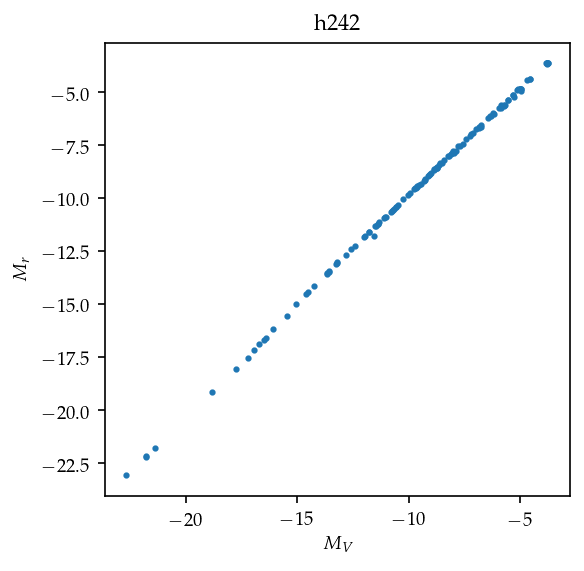

In [165]:
Mv = np.array(data.V_mag, dtype=float)
Mr = np.array(data.r_mag, dtype=float)

slope, intercept, r_value, p_value, std_err = stats.linregress(Mv,Mr)

print(f'Mr = Mv * {slope:.2f} + {intercept:.2f}')



plt.figure(dpi=150,figsize=(4,4))

plt.scatter(Mv,Mr,s=4)

# plt.plot(np.sort(Mv), slope*np.sort(Mv)+intercept)

plt.xlabel('$M_V$')
plt.ylabel('$M_r$')
plt.title('h242')

# plt.xlim(-22.5,-2.5)
# # plt.ylim(-22.5,-2.5)
# plt.ylim(-0.25,0.25)

plt.show()

In [166]:
Mstar = np.array(data.M_star,dtype=float)
Lr = 10**((4.65 - Mr)/2.5) # Absolute magnitude (AB) of Sun in SDSS r-band
slope, intercept, r_value, p_value, std_err = stats.linregress(Lr, Mstar)
print(f'M* = Lr * {slope:.2f} + {intercept:.2e}')

M* = Lr * 1.64 + 1.50e+08


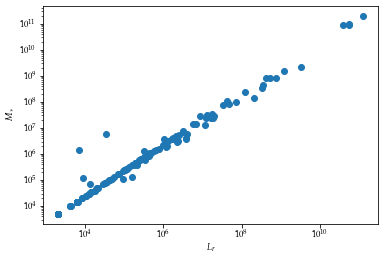

In [167]:
plt.scatter(Lr, Mstar)
plt.loglog()
plt.xlabel(r'$L_r$')
plt.ylabel(r'$M_{*}$')
plt.show()

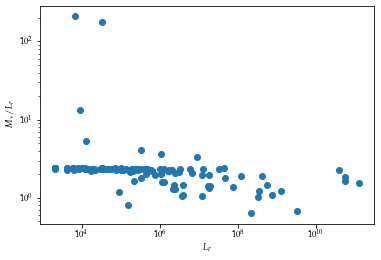

In [168]:
Lr = 10**((4.65 - Mr)/2.5)
np.mean(Mstar/Lr)

plt.scatter(Lr, Mstar/Lr)
plt.loglog()
plt.xlabel(r'$L_r$')
plt.ylabel(r'$M_*/L_r$')
plt.show()

In [169]:
Y = Mstar/Lr
np.median(Y[Mr < -12.3])



1.587617461029179

26.07910676126098


(array([96.,  9.,  4.,  8.,  2.,  1.,  0.,  0.,  0.,  5.]),
 SimArray([4.80072603e-05, 2.91176384e+02, 5.82352720e+02, 8.73529055e+02,
           1.16470539e+03, 1.45588173e+03, 1.74705806e+03, 2.03823440e+03,
           2.32941073e+03, 2.62058707e+03, 2.91176341e+03]),
 <a list of 10 Patch objects>)

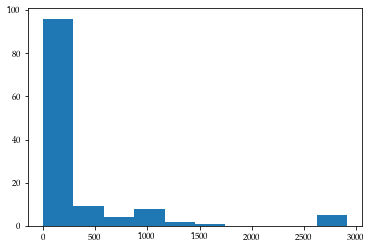

In [141]:


Y = Mstar/Lr
print(np.median(Y))

Y_clean = np.delete(Y,np.argmax(Y))
Y_clean = np.delete(Y_clean,np.argmax(Y_clean))
Y_clean = np.delete(Y_clean,np.argmax(Y_clean))

plt.hist(Y_clean)

In [62]:
def read_file(path):
    data = []
    with open(path,'rb') as f:
        while True:
            try: 
                data.append(pickle.load(f, encoding='latin1'))
            except EOFError:
                break
    data = pd.DataFrame(data)

    return data

In [63]:
sunrise = read_file('../../F19/sunrise_mags.data')

matched_ids = pd.read_csv('../../F19/sunrise_match.csv')
matched_ids = matched_ids[matched_ids['do we have sunrise data?']=='Yes']

matched_ids['key'] = [str(sim)+'-'+str(i) for sim,i in zip(matched_ids['simulation'], matched_ids['matched old id'])]

sunrise['key'] = [str(sim)+'-'+str(i) for sim,i in zip(sunrise['sim'], sunrise['haloid'])]
merged = pd.merge(matched_ids, sunrise, left_on='key', right_on='key')

merged['key'] = [str(sim)+'-'+str(i) for sim,i in zip(merged['sim'], merged['200 bgk dens ID'])]
merged

,simulation,200 bgk dens ID,matched old id,id difference,do we have sunrise data?,key,sim,haloid,M_r,M_g,M_u,M_i,M_v
0,h148,2,2,0,Yes,h148-2,h148,2,-19.380166,-19.006667,-18.051331,-19.526333,-19.213652
1,h148,3,3,0,Yes,h148-3,h148,3,-18.518809,-18.071981,-17.057268,-18.705120,-18.335558
2,h148,5,5,0,Yes,h148-5,h148,5,-17.139907,-16.723978,-15.746194,-17.307755,-16.968644
3,h148,6,6,0,Yes,h148-6,h148,6,-16.945385,-16.573120,-15.662628,-17.092861,-16.783981
4,h148,10,10,0,Yes,h148-10,h148,10,-13.887727,-13.435007,-12.402113,-14.069254,-13.713870
5,h148,11,11,0,Yes,h148-11,h148,11,-16.494629,-16.207684,-15.369102,-16.602673,-16.364633
6,h148,13,12,-1,Yes,h148-13,h148,12,-14.833878,-14.190606,-12.915137,-15.078250,-14.604174
7,h148,14,14,0,Yes,h148-14,h148,14,-13.477971,-13.068797,-12.019128,-13.656438,-13.328127
8,h148,21,18,-3,Yes,h148-21,h148,18,-12.261699,-11.843441,-10.733548,-12.436491,-12.112513
9,h148,27,26,-1,Yes,h148-27,h148,26,-15.430822,-14.928492,-13.840093,-15.633196,-15.240207


In [159]:
sunrise_MtoL, data_MtoL, Mstars = [], [], []
for sim, haloid in zip(list(data.sim),list(data.haloid)):
    s = merged[(merged['200 bgk dens ID']==haloid)&(merged.sim==sim)]
    if len(s)!=0:
        d = data[data.haloid==haloid]
        Mr_s = s.M_r.tolist()[0]
        Mr_d = d.r_mag.tolist()[0]
        Lr_s = 10**((4.53 - Mr_s)/2.5)
        Lr_d = 10**((4.65 - Mr_d)/2.5)
        Mstar = d.M_star.tolist()[0]
        print(f'{sim}-{haloid}: Sunrise says M_r = {Mr_s:.2f}, pynbody says M_r = {Mr_d:.2f}, difference = {Mr_s - Mr_d:.2f}')
        sunrise_MtoL.append(Mstar/Lr_s)
        data_MtoL.append(Mstar/Lr_d)
        Mstars.append(Mstar)

h242-12: Sunrise says M_r = -17.35, pynbody says M_r = -16.91, difference = -0.44
h242-40: Sunrise says M_r = -9.81, pynbody says M_r = -9.50, difference = -0.31
h242-80: Sunrise says M_r = -13.52, pynbody says M_r = -13.06, difference = -0.46
h148-2: Sunrise says M_r = -19.38, pynbody says M_r = -19.15, difference = -0.23
h148-3: Sunrise says M_r = -18.52, pynbody says M_r = -18.07, difference = -0.45
h148-5: Sunrise says M_r = -17.14, pynbody says M_r = -16.71, difference = -0.43
h148-6: Sunrise says M_r = -16.95, pynbody says M_r = -16.63, difference = -0.31
h148-10: Sunrise says M_r = -13.89, pynbody says M_r = -17.19, difference = 3.30
h148-11: Sunrise says M_r = -16.49, pynbody says M_r = -16.17, difference = -0.32
h148-13: Sunrise says M_r = -14.83, pynbody says M_r = -14.45, difference = -0.38
h148-14: Sunrise says M_r = -13.48, pynbody says M_r = -13.03, difference = -0.45
h148-21: Sunrise says M_r = -12.26, pynbody says M_r = -11.80, difference = -0.46
h148-27: Sunrise says M

In [160]:
np.median(sunrise_MtoL)

1.1060614710622534

In [161]:
np.median(data_MtoL)

1.4609406843570798

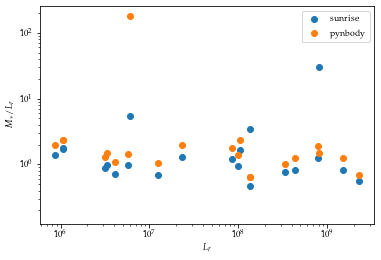

In [137]:
plt.scatter(Mstars, sunrise_MtoL, label='sunrise')
plt.scatter(Mstars, data_MtoL, label='pynbody')
plt.loglog()
plt.xlabel(r'$L_r$')
plt.ylabel(r'$M_*/L_r$')
plt.legend()
plt.show()

In [124]:
np.mean(Mr-Mv)

0.11977422673180733

In [75]:
# r      =    V - 0.46*(B-V) + 0.11
r_test = data.V_mag - 0.46 * (data.B_mag - data.V_mag) + 0.11
Lr_test = 10**((Mr_sol - r_test)/2.5)
print(np.mean(Mstar/Lr_test))

1.9834642329718017


In [171]:
Mr_sol = 4.65
L_r = 10**((Mr_sol - (-12.3))/2.5)
print(f'Using M/L of 1, SAGA completeness limit is M_* ~ {L_r:.2e} Msol')
print(f'Using M/L of 1.588, SAGA completeness limit is M_* ~ {1.588*L_r:.2e} Msol')
print(f'Using M/L of 2.3, SAGA completeness limit is M_* ~ {2.3*L_r:.2e} Msol')

Using M/L of 1, SAGA completeness limit is M_* ~ 6.03e+06 Msol
Using M/L of 1.588, SAGA completeness limit is M_* ~ 9.57e+06 Msol
Using M/L of 2.3, SAGA completeness limit is M_* ~ 1.39e+07 Msol


(Median M/L for only those satellites brighter than M_r of -12.3 is 1.588)

In [7]:


Mr_sol = 4.65
L_r = 10**((Mr_sol - (-13))/2.5)
Mstar = 1.5*L_r
print(f'{Mstar:.2e}')

1.09e+08


In [6]:
import numpy as np
np.log10(1e8/1.5)*2.5 - Mr_sol

14.909771852360796

In [17]:
import pickle
import pandas as pd
def read_z0(simname):
    '''Function to read in the data file which contains z=0 information for the various halos.'''
    data = []
    with open('../../Data/z0_data/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data1 = pd.DataFrame(data)
    data1['sim'] = simname
    return data1

data = read_z0('h148')
data = data.append(read_z0('h229'))
data = data.append(read_z0('h242'))
data = data.append(read_z0('h329'))

data.keys()

Index(['haloid', 'hostHalo', 'n_particles', 'n_star', 'n_gas', 'M_star',
       'M_gas', 'mass', 'Rvir', 'G_outflow_2.5', 'G_outflow_1.5',
       'G_inflow_2.5', 'G_inflow_1.5', 'G_inflow_0', 'G_outflow_0', 'Gout_T',
       'Gin_T', 'Xc', 'Yc', 'Zc', 'feh_avg', 'zstar', 'zgas', 'g_temp',
       'V_mag', 'B_mag', 'U_mag', 'R_mag', 'I_mag', 'r_mag', 'gasfrac', 'mHI',
       'HIgasfrac', 'sfh', 'sfhbins', 'SFR', 'sSFR', 'tquench', 'age', 'B-V',
       'h1dist', 'id2', 'Rmax', 'ovdens', 'fMhires', 'c_a', 'c', 'a',
       'V90_Vdisp', 'hostVirialR', 'hostDist', 'sim'],
      dtype='object')

In [60]:
sims = np.array(data.sim, dtype=str)
haloids = np.array(data.haloid,dtype=int)
M_star = np.array(data.M_star,dtype=float)
M_halo = np.array(data.mass,dtype=float)-np.array(data.M_gas,dtype=float)-M_star
M_r = np.array(data.r_mag,dtype=float)
SFR = np.array(data.SFR,dtype=float)
sSFR = np.array(data.sSFR,dtype=float)
quenched = sSFR < 1e-11


output = {
    'sim':sims,
    'haloid':haloids,
    'M_star':M_star,
    'M_halo':M_halo,
    'M_r':M_r,
    'SFR':SFR,
    'sSFR':sSFR,
    'quenched':quenched
}
output = pd.DataFrame(output)
output.to_csv('satellites.csv',index=False)

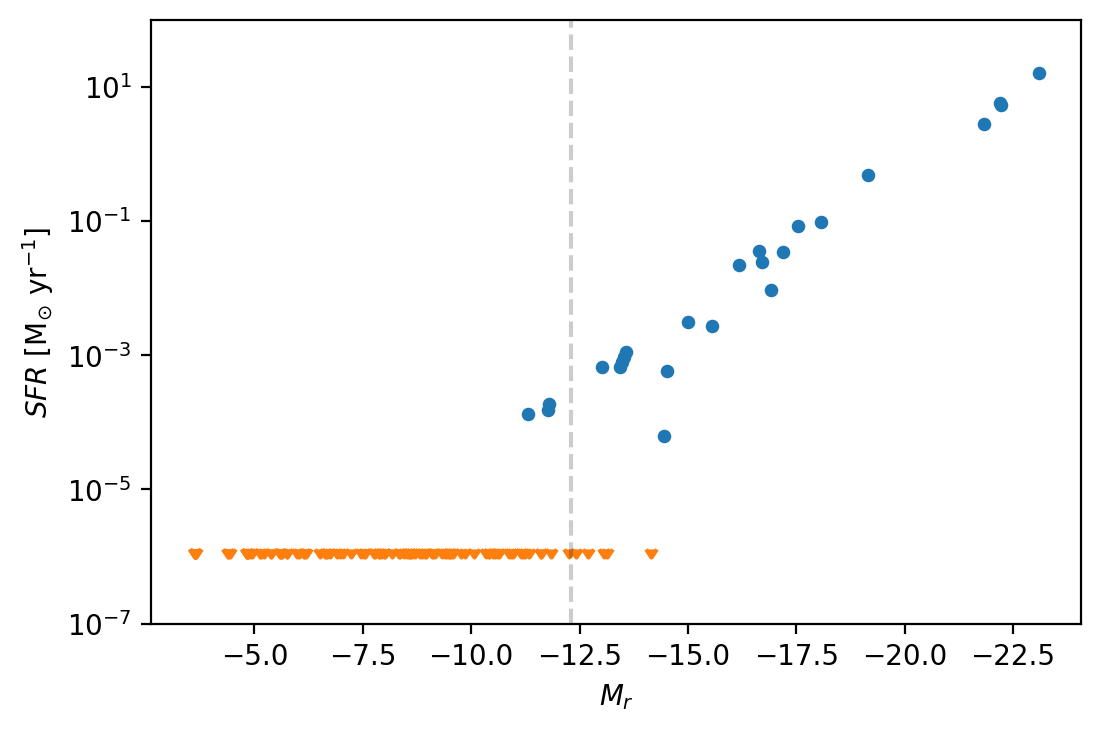

In [66]:
import matplotlib.pyplot as plt

plt.figure(dpi=200)
plt.scatter(M_r, SFR, s=15)
plt.scatter(M_r[SFR==0], [1e-6]*len(M_r[SFR==0]), s=15, marker=7)
plt.semilogy()
plt.ylim(1e-7,1e2)
plt.gca().invert_xaxis()

plt.plot([-12.3,-12.3],[1e-7,1e2],'k--',alpha=0.2)
plt.xlabel(r'$M_r$')
plt.ylabel(r'$SFR~[\mathrm{M}_{\odot}~\mathrm{yr}^{-1}]$')

plt.savefig('SFR_Mr.png',dpi=300)

plt.show()

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


27


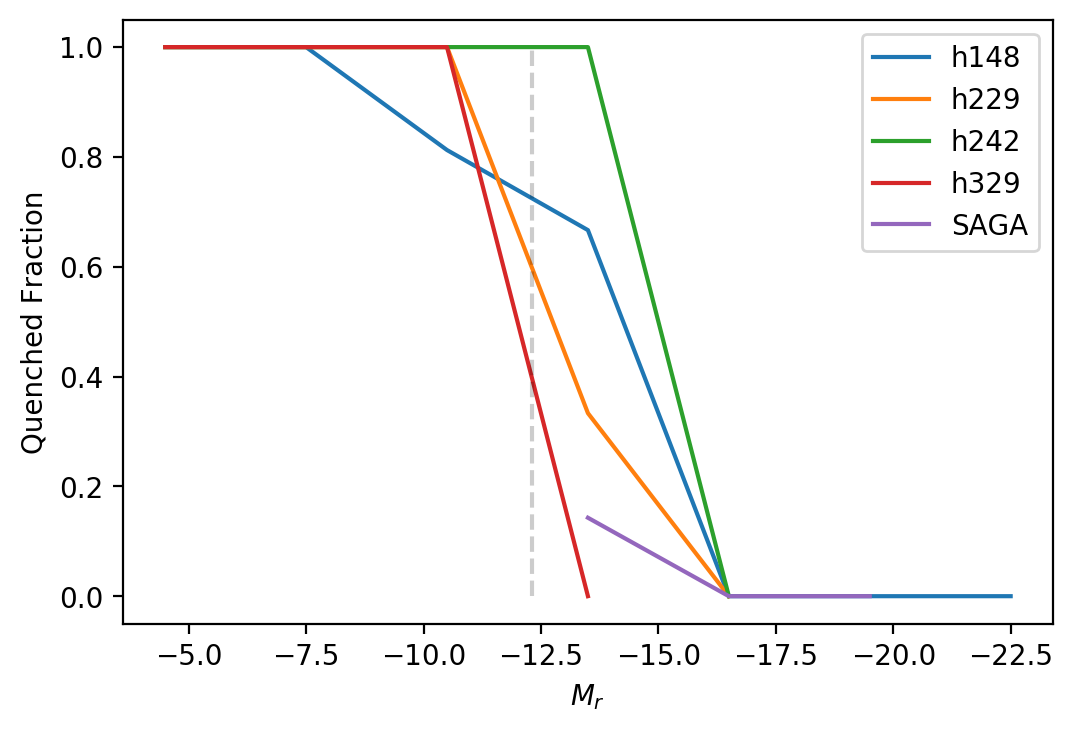

In [69]:
plt.figure(dpi=200)

bin_edges = np.arange(-24,-2,3) 

for sim in np.unique(sims):
    M_r_temp = M_r[sims==sim]
    quenched_temp = quenched[sims==sim]
    


    y1, binEdges = np.histogram(M_r_temp, bin_edges)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    y2, binEdges = np.histogram(M_r_temp[quenched_temp], bins = binEdges)
    y = y2/y1
    plt.plot(bincenters,y, linewidth=1.5, label=sim)

# add Geha et al. (2017) data (SAGA)
SAGA = pd.read_csv('../QuenchedFractions/SAGA_data_cleaned.csv')
SAGA = SAGA[SAGA['complete'] == 'Y'] # remove those galaxies below the limit for full detection
SAGA = SAGA[SAGA['M_r'] < -12.3] # remove those galaxies below the limit for full detection
print(len(SAGA))
SAGA_M_r = np.array(SAGA.M_r,dtype=float)

y1, binEdges = np.histogram(SAGA_M_r, bin_edges)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
y2, binEdges = np.histogram(SAGA_M_r[SAGA.halpha=='N'], bins = binEdges)
y = y2/y1
plt.plot(bincenters,y,linewidth=1.5, label='SAGA')

plt.gca().invert_xaxis()
plt.xlabel(r'$M_r$')
plt.ylabel('Quenched Fraction')
plt.plot([-12.3,-12.3],[0,1],'k--',alpha=0.2)

plt.legend()

plt.savefig('QF_Mr.png',dpi=300)
plt.show()